In [1]:
import sys
sys.path.append("..")
path= "../"

import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import copy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import pickle
import os
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2
plt.style.use(f'article.mplstyle')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load data

In [2]:
df_real = pd.read_pickle(f"{path}output/real.pkl")

In [3]:
df_balanced = pd.read_pickle(f"{path}output/balanced.pkl")

In [4]:
df_imbalanced = pd.read_pickle(f"{path}output/imbalanced.pkl")

In [5]:
# Rename method labels
ours = ['Baseline k-means', 'Cluster NN', 'Ensemble K-means',
       'contrastive-sc']

df_balanced["ours"] = df_balanced["variable"].apply(
    lambda x: 'Ensemble Leiden (contrastive-sc)'
    if x == 'contrastive-sc' else x)
df_imbalanced["ours"] = df_imbalanced["variable"].apply(
    lambda x: 'Ensemble Leiden (contrastive-sc)'
    if x == 'contrastive-sc' else x)

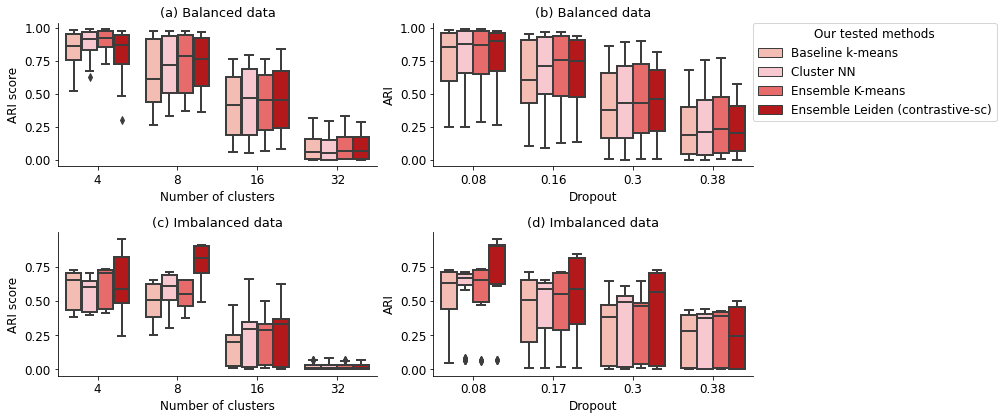

In [6]:
clrs = [
    '#feb6aa',
    'pink',
    '#fd5658',
    '#cc0001',
]
plt.figure(figsize=(14, 6))
ax = plt.subplot(2, 2, 1)
sns.boxplot(x="nclust",
            y="value",
            hue="ours",
            palette=clrs,
            data=df_balanced[df_balanced["variable"].isin(ours)],
            ax=ax)
plt.legend([], [], frameon=False)
plt.xlabel("Number of clusters")
plt.ylabel("ARI score")
plt.title(f"(a) Balanced data")

ax = plt.subplot(2, 2, 2)
sns.boxplot(x="dp",
            y="value",
            hue="ours",
            palette=clrs,
            data=df_balanced[df_balanced["variable"].isin(ours)].sort_values(
                by=["dp", "order"]),
            ax=ax)
plt.xlabel("Dropout")
plt.ylabel("ARI")
plt.legend([], [], frameon=False)
plt.title(f"(b) Balanced data")
plt.legend(title="Our tested methods",
           bbox_to_anchor=(1, 1),
           loc=2,
           borderaxespad=0.)


ax = plt.subplot(2, 2, 3)
sns.boxplot(x="nclust",
            y="value",
            hue="ours",
            palette=clrs,
            data=df_imbalanced[df_imbalanced["variable"].isin(ours)],
            ax=ax)
plt.legend([], [], frameon=False)
plt.xlabel("Number of clusters")
plt.ylabel("ARI score")
plt.title(f"(c) Imbalanced data")

ax = plt.subplot(2, 2, 4)
sns.boxplot(x="dp",
            y="value",
            hue="ours",
            palette=clrs,
            data=df_imbalanced[df_imbalanced["variable"].isin(ours)].sort_values(
                by=["dp", "order"]),
            ax=ax)
plt.xlabel("Dropout")
plt.ylabel("ARI")
plt.legend([], [], frameon=False)
plt.title(f"(d) Imbalanced data")

sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/ours.pdf", bbox_inches='tight')

# Average results across all datasets

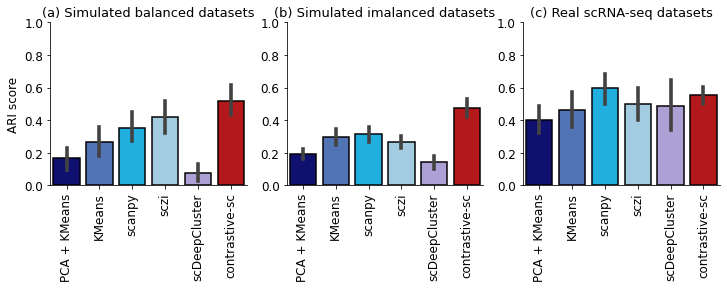

In [8]:
methods = ['PCA + KMeans', 'KMeans', 'scanpy', 'sczi', 'scDeepCluster', 'contrastive-sc']
clrs = [
    'navy', '#416ec5', 'deepskyblue', '#9acfea', "#a897dd",  '#cc0001'
]
plt.figure(figsize=(12, 3))
plt.subplot(131)
sns.barplot(
    x="variable",
    y="value",
    data=df_balanced[df_balanced["variable"].isin(methods)],
    palette=clrs,
    edgecolor='black',
    linewidth=1.5,
)
plt.title("(a) Simulated balanced datasets")
plt.ylim((0, 1))
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("ARI score")
sns.despine()

plt.subplot(132)
sns.barplot(
    x="variable",
    y="value",
    data=df_imbalanced[df_imbalanced["variable"].isin(methods)],
    palette=clrs,
    edgecolor='black',
    linewidth=1.5,
)
plt.title("(b) Simulated imalanced datasets")
plt.ylim((0, 1))
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
sns.despine()

plt.subplot(133)
sns.barplot(
    x="variable",
    y="value",
    data=df_real[df_real["variable"].isin(methods)],
    palette=clrs,
    edgecolor='black',
    linewidth=1.5,
)
plt.title("(c) Real scRNA-seq datasets")
plt.ylim((0, 1))
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
sns.despine()

plt.savefig(f"{path}diagrams/methods_comparaison.pdf", bbox_inches='tight')

# Common plot Dropout impact vs nb of predictors in ensemble

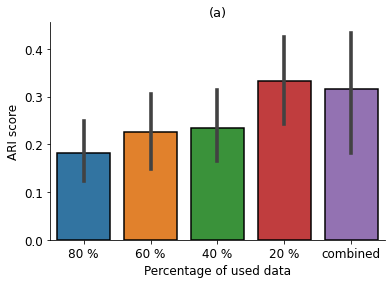

In [8]:
category = "imbalanced_data"
dropout = pd.read_pickle(f"{path}output/pickle_results/{category}/real_data_augmentation.pkl")

def get_label(x):
    if x == -1: 
        return "combined"
    if x == 100:
        return "80 %"
    if x == 200:
        return "60 %"
    if x == 300:
        return "40 %"
    if x == 400:
        return "20 %"

dropout["label"] = dropout["nd"].apply(get_label)

plt.title("(a)")
sns.barplot(
    x="label",
    y="ari",
    data=dropout,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Percentage of used data")
plt.ylabel("ARI score")
sns.despine()
# plt.savefig(f"{path}diagrams/dropoutopout.pdf", bbox_inches='tight')

In [11]:
category = "balanced"

all_df = None
for run in range(3):
    for name in [f"{path}output/pickle_results/{category}_{run}.pkl"]:
        df = pd.read_pickle(name)
        df["run"] = run
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat([all_df, df], ignore_index=True)
            
columns = [

    'nclust',
    'dropout',
    'self0_initial_3_500',
    'combined_features10_500',
    'combined_features3_500',
    'combined_features5_500',
]

nb_pred_map = {
        'self0_initial_3_500':1,
    'combined_features10_500':10,
    'combined_features3_500':3,
    'combined_features5_500':5,
}

df1 = all_df[columns]

df1 =pd.melt(df1, id_vars=[ 'dropout',  'nclust'])
df1[ 'nclust']=df1[ 'nclust'].astype(int)
df1["n_predictors"]=df1["variable"].apply(lambda x: nb_pred_map[x])


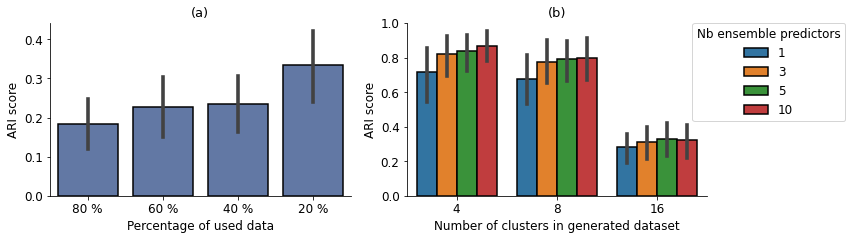

In [12]:
plt.figure(figsize=(12, 3.5))
plt.subplot(121)

plt.title("(a)")
sns.barplot(
    x="label",
    y="ari",
    data=dropout[dropout["label"]!= "combined"],
    color='#416ec5', saturation=.5,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Percentage of used data")
plt.ylabel("ARI score")
sns.despine()

ax = plt.subplot(122)
plt.title("(b)")
sns.barplot(
    data=df1,
    x="nclust",
    y="value",
    hue="n_predictors",
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Number of clusters in generated dataset")
plt.ylabel("ARI score")
ax.set_xticklabels([ 4, 8, 16])
plt.legend(title = "Nb ensemble predictors", bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/dropout_and_nb_repr.pdf", bbox_inches='tight')